In [1]:
import re
import xlrd
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
df = pd.read_excel('../data/Results.xlsx', sheetname='First', skiprows=2)
df = df.select(lambda column: not column.startswith('Unnamed'), axis=1)
df = df[df['Address'].notnull()]

subthreshold = re.compile(r'<1')
for draw in ['1st Draw', '3 Minute', '5 Minute']:
    df[draw] = pd.to_numeric(df[draw].replace(subthreshold, 0), errors='coerce')

,1st Draw,3 Minute,5 Minute
1st Draw,1.000000,0.167445,0.186306
3 Minute,0.167445,1.000000,0.719992
5 Minute,0.186306,0.719992,1.000000


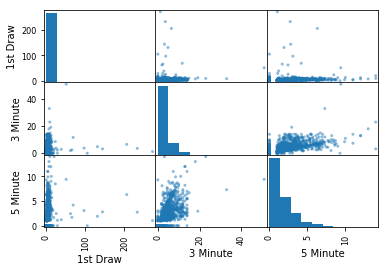

In [3]:
pd.plotting.scatter_matrix(df)
df.corr()

In [4]:
import os
import glob
import json
import urllib

geodata = {}
for path in glob.glob('../geodata/chicago-water-lead/*.json'):
    key = os.path.splitext(os.path.split(path)[-1])[0].lower()
    with open(path) as fp:
        geodata[key] = json.load(fp)

def get_lat(row):
    key = urllib.parse.quote_plus(row['Address']).lower()
    data = geodata[key]
    return float(data['OutputGeocodes'][0]['OutputGeocode']['Latitude'])
def get_lon(row):
    key = urllib.parse.quote_plus(row['Address']).lower()
    data = geodata[key]
    return float(data['OutputGeocodes'][0]['OutputGeocode']['Longitude'])
    
df['lat'] = df.apply(get_lat, axis=1)
df['lon'] = df.apply(get_lon, axis=1)
df['lead_bin'] = pd.cut(df['1st Draw'], [0, 5, 15, df['1st Draw'].max()], include_lowest=True, labels=['<5', '<15', '>=15'])

In [5]:
from bokeh.io import output_notebook, show
from bokeh.models import (
    GMapPlot, GMapOptions, ColumnDataSource, Circle,
    DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, Jitter, Legend, LegendItem
)

In [6]:
plot = GMapPlot(
    x_range=DataRange1d(),
    y_range=DataRange1d(),
    map_options=GMapOptions(lat=41.8781, lng=-87.6298, map_type="roadmap", zoom=10),
)
plot.api_key = os.getenv('GMAPS_API_KEY')

levels = [
    {'bin': '<5', 'color': '#000000'},
    {'bin': '<15', 'color': '#ffff00'},
    {'bin': '>=15', 'color': '#ff0000'},
]
renderers = []
for level in levels:
    circle = Circle(
        x={'field': "lon", 'transform': Jitter(width=0.001)}, 
        y={'field': "lat", 'transform': Jitter(width=0.001)},
        fill_color=level['color'],
        line_color=None,
    )
    renderer = plot.add_glyph(ColumnDataSource(df[df['lead_bin'] == level['bin']]), circle)
    renderers.append(renderer)

legend = Legend(
    items=[LegendItem(label=levels[idx]['bin'], renderers=[renderers[idx]]) for idx in range(len(levels))],
    location='bottom_left',
    orientation='vertical',
    border_line_color='black',
)
plot.add_layout(legend, 'left')
plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool())

output_notebook()
show(plot)

Loading BokehJS ...